# Data Mining Project

Prosper WANG, Antoine VANSIELEGHEM

## 1: Imports and Setup

We begin by importing all the required libraries.

In [63]:
#os and files handling
import os
import string
import zipfile
from datasets import load_dataset
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter
import pandas as pd

#web scrapping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

#NLP
import nltk
import spacy
from nltk.tag import UnigramTagger
from nltk.corpus import treebank
from nltk.tag import UnigramTagger
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('treebank')
nltk.download('maxent_ne_chunker')
nltk.download('words')

#Machine Learning
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

#Knowledge Graphs
import rdflib   
from rdflib import Graph, Namespace, URIRef

#Deep learning
import torch

#Data Vizualization
import matplotlib.pyplot as plt
import networkx as nx

#Knowledge graph embedding
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## 2: Text Preprocessing

We define a function to clean raw text: removing punctuation, lowercasing, tokenizing, removing stopwords, and lemmatizing tokens.

In [64]:
def clean_text(text):
    punctuation = string.punctuation.replace('-', '')
    text = text.translate(str.maketrans('', '', punctuation)).lower()
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens if w not in stop_words])

## 3: Load spaCy Models

We define a function to load our pre-trained, zipped spaCy NER model along with the default English model.

In [65]:
def load_models():
    zip_path = "en_ner_conll03.zip"
    extract_dir = "./en_ner_conll03_model"
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    nlp_ner = spacy.load(os.path.join(extract_dir, "best_ner_model"))
    nlp = spacy.load("en_core_web_sm")
    return nlp_ner, nlp

### Training and Comparing NER Models with CRF
We will now train a Conditional Random Fields (CRF) model using the CoNLL-2003 dataset.
This model will be used to extract named entities from text, allowing us to later extract structured triples.

In [66]:
def train_and_compare_ner_models():
    tagger = UnigramTagger(treebank.tagged_sents())
    def safe_pos_tag(words): return tagger.tag(words)

    def word2features(sent, i):
        word, postag = sent[i][0], sent[i][1] or "NN"
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'postag': postag,
            'postag[:2]': postag[:2],
        }
        if i > 0:
            word1, postag1 = sent[i-1][0], sent[i-1][1] or "NN"
            features.update({'-1:word.lower()': word1.lower(), '-1:postag': postag1, '-1:postag[:2]': postag1[:2]})
        else:
            features['BOS'] = True
        if i < len(sent)-1:
            word1, postag1 = sent[i+1][0], sent[i+1][1] or "NN"
            features.update({'+1:word.lower()': word1.lower(), '+1:postag': postag1, '+1:postag[:2]': postag1[:2]})
        else:
            features['EOS'] = True
        return features

    def extract_features(sent): 
        return [word2features(sent, i) for i in range(len(sent))]
    def get_labels(sent): 
        return [label for token, postag, label in sent]

    dataset = load_dataset("conll2003")
    ner_tags = dataset['train'].features['ner_tags'].feature.names
    train_data = [
        [(w, pos or "NN", ner_tags[t]) for w, (w2, pos), t in zip(row['tokens'], safe_pos_tag(row['tokens']), row['ner_tags'])]
        for row in dataset['train'].select(range(500))]

    test_data = [
        [(w, pos or "NN", ner_tags[t]) for w, (w2, pos), t in zip(row['tokens'], safe_pos_tag(row['tokens']), row['ner_tags'])]
        for row in dataset['test'].select(range(100))]

    X_train, y_train = [extract_features(s) for s in train_data], [get_labels(s) for s in train_data]
    X_test, y_test = [extract_features(s) for s in test_data], [get_labels(s) for s in test_data]

    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)
    print("\n CRF Evaluation:")
    print(metrics.flat_classification_report(y_test, y_pred))
    return crf, tagger


Now we can execute the function and look at the evaluations

In [67]:
# Train the CRF model
crf_model, tagger = train_and_compare_ner_models()


 CRF Evaluation:
              precision    recall  f1-score   support

       B-LOC       0.90      0.79      0.84        82
      B-MISC       0.86      0.86      0.86        22
       B-ORG       0.00      0.00      0.00         2
       B-PER       0.93      0.89      0.91       111
       I-LOC       0.75      0.33      0.46         9
      I-MISC       0.67      0.83      0.74        12
       I-ORG       0.00      0.00      0.00         1
       I-PER       0.93      0.99      0.96        97
           O       0.98      0.99      0.98      1086

    accuracy                           0.96      1422
   macro avg       0.67      0.63      0.64      1422
weighted avg       0.96      0.96      0.96      1422



c:\Users\antoi\Desktop\DataMining_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoi\Desktop\DataMining_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoi\Desktop\DataMining_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In term of performance:
-The model achieved an accuracy of 96%, which is excellent. This means the model is correctly predicting the majority of the tokens in the dataset.
-The weighted average F1-score is also 96%, indicating that the model performs well across all classes, especially for the more frequent ones.

Now, for the classes:
-B-LOC: Precision: 90%, Recall: 79%, F1-Score: 84%.
The model is good at identifying location entities, but the recall could be improved. It misses some location entities, which lowers the recall.

-B-MISC: Precision: 86%, Recall: 86%, F1-Score: 86%.
The performance is balanced for this class, with both precision and recall being high.

-B-ORG: Precision: 0%, Recall: 0%, F1-Score: 0%.
The model completely fails to identify organization entities. This is likely due to the very small number of examples in the dataset (support = 2). The model needs more training data for this class.

-B-PER: Precision: 93%, Recall: 89%, F1-Score: 91%.
The model performs very well for person entities, with high precision and recall.

B-PER: Precision: 93%, Recall: 89%, F1-Score: 91%.
The model performs very well for person entities, with high precision and recall.

-I-LOC: Precision: 75%, Recall: 33%, F1-Score: 46%.
The model struggles with inside location entities, as seen in the low recall. This could be due to the small number of examples (support = 9).

-I-MISC: Precision: 67%, Recall: 83%, F1-Score: 74%.
The model performs decently here, but the precision is lower, meaning it sometimes predicts this class incorrectly.

-I-ORG:Precision: 0%, Recall: 0%, F1-Score: 0%.
Similar to B-ORG, the model fails to identify inside organization entities due to insufficient training examples (support = 1).

-I-PER: Precision: 93%, Recall: 99%, F1-Score: 96%.
The model performs exceptionally well for inside person entities, with near-perfect recall.

-O: Precision: 98%, Recall: 99%, F1-Score: 98%.
The model performs extremely well for tokens outside named entities, which is expected since this is the most frequent class (support = 1086).


Conclusion: The CRF model performs very well overall, especially for frequent classes like "O" and "B-PER". However, it struggles with rare classes like B-ORG and I-ORG, highlighting the need for more balanced training data and further optimization.



## Entity Extraction using the CRF Model
Using the CRF model we trained, we now define a function to extract named entities from any input text.

In [68]:
def extract_entities_with_crf(text, crf_model, tagger):
    tokens = nltk.word_tokenize(text)
    tagged = tagger.tag(tokens)
    sent = [(w, tag or "NN") for w, tag in tagged]
    features = []
    for i in range(len(sent)):
        word, postag = sent[i]
        feats = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'postag': postag,
            'postag[:2]': postag[:2],
            'BOS': i == 0,
            'EOS': i == len(sent) - 1,
        }
        if i > 0:
            word1, postag1 = sent[i-1]
            feats.update({'-1:word.lower()': word1.lower(), '-1:postag': postag1, '-1:postag[:2]': postag1[:2]})
        if i < len(sent) - 1:
            word1, postag1 = sent[i+1]
            feats.update({'+1:word.lower()': word1.lower(), '+1:postag': postag1, '+1:postag[:2]': postag1[:2]})
        features.append(feats)
    tags = crf_model.predict_single(features)
    entities, current_entity, current_label = [], [], None
    for token, tag in zip(tokens, tags):
        if tag.startswith("B-"):
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity, current_label = [token], tag[2:]
        elif tag.startswith("I-") and current_label:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity, current_label = [], None
    if current_entity:
        entities.append((" ".join(current_entity), current_label))
    return entities


We can now test the functions on the provided text 

In [69]:
text = """Star Wars IV is a Movie where there are different kinds of creatures, like 
humans and wookies. Some creatures are Jedis; for instance, the human Luke 
is a Jedi, and Master Yoda - for whom the species is not known - is also a 
Jedi. The wookie named Chewbacca is Han's co-pilot on the Millennium 
Falcon starship. The speed of Millennium Falcon is 1.5 (above the speed of 
light!)"""

entities = extract_entities_with_crf(text, crf_model, tagger)

print("Extracted Entities:")
for entity, label in entities:
    print(f"{entity} ({label})")

Extracted Entities:
Star Wars (PER)
Movie (LOC)
Jedis (PER)
Jedi (LOC)
Master Yoda (PER)
Jedi (MISC)
Chewbacca (PER)
Han (LOC)
Millennium Falcon (PER)
Millennium Falcon (PER)


The CRF model extracted several entities from the provided text, but there were many misclassifications. For example, "Star Wars" was incorrectly labeled as a person, even though it is a movie title and should likely be classified as miscellaneous. Similarly, "Movie" was labeled as a location, which is incorrect since it is not an entity at all. While some classifications were accurate, such as "Master Yoda" and "Chewbacca" being identified as persons, others like "Millennium Falcon" were mislabeled as a person instead of miscellaneous, and it was also extracted twice, showing redundancy in the output.

## Fetching Articles from BBC
We use Selenium to dynamically fetch articles from BBC
Each article's title, content, date, and URL are stored for processing.
We use the BBC news technology category because the reuters website requires a CAPATCHA and I did not succeed in bypassing it.

In [70]:
def fetch_bbc_articles():
    url = "https://www.bbc.com/news/technology"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Failed to retrieve the BBC page.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    articles = []
    seen_titles = set()

    for article_tag in soup.find_all("h2"):
        title = article_tag.get_text(strip=True)
        parent_link = article_tag.find_parent("a")
        content_tag = article_tag.find_next("p")
        summary = content_tag.get_text(strip=True) if content_tag else "No summary available"

        date_tag = article_tag.find_next("div")
        date_span = date_tag.find("span") if date_tag else None
        publication_date = date_span.get_text(strip=True) if date_span else "Unknown date"
        author_span = date_span.find_next_sibling("span") if date_span else None
        author = author_span.get_text(strip=True) if author_span else "Unknown author"

        if parent_link and "href" in parent_link.attrs:
            link = parent_link["href"]
            if not link.startswith("http"):
                link = f"https://www.bbc.com{link}"

            try:
                article_response = requests.get(link, headers=headers)
                article_soup = BeautifulSoup(article_response.text, "html.parser")
                paragraphs = article_soup.find_all(["p", "h2"])
                full_text = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))
                if len(full_text) < 100:
                    full_text = "Full text not available"
            except Exception as e:
                full_text = f"Error loading article: {e}"

            if title not in seen_titles:
                seen_titles.add(title)
                articles.append({
                    "title": title,
                    "url": link,
                    "summary": summary,
                    "date": publication_date,
                    "author": author,
                    "content": full_text
                })

        if len(articles) == 10:
            break

    return articles


We can print the fetched articles

In [71]:
articles = fetch_bbc_articles()
for art in articles:
    print(f"\n{art['title']}\n{art['url']}\n{art['content'][:300]}...\n")



Why you might not need a phone case anymore
https://www.bbc.com/future/article/20250410-why-your-phone-doesnt-need-a-case-anymore
With smartphones tougher than ever, a new wave of phone minimalists say cases are for cowards. I joined the case-free cult, called the experts and braced for the sound of broken glass. A few months ago I walked into an Apple store to buy a new iPhone. After sifting through models and upgrades, a che...


How climate change is supercharging allergies
https://www.bbc.com/future/article/20250410-how-climate-driven-thunderstorms-supercharge-pollen-allergies
Seasonal allergy sufferers are being hit with more pollen over a longer season due to rising temperatures, but global warming is also triggering alarming extreme allergy events, say experts. People could see the thunderstorm, but they couldn't see what was going on inside it. Trillions of pollen par...


Tech Decoded: Sign up to our newsletter
https://cloud.email.bbc.com/techdecoded-newsletter-signup?&at_bbc

We successfully fetch the title, link and content of the articles.

## Extracting Subject-Predicate-Object Triples
We use a rule-based approach with spaCy to extract SPO triples from article content.
This step lays the foundation for building our knowledge graph.
We added extra rules to extract more useful relations from the text. The original rule only captured subject-verb-object patterns with prepositions. We improved it by adding:

Direct object rule: catches verbs and their direct objects.

Attribute and copula rule: finds identity statements like “X is Y”.

Appositive rule: handles descriptions like “Yoda, a Jedi Master”.

Compound rule: links parts of names like “Millennium Falcon”.

In [72]:
def extract_relations(text, nlp):
    doc = nlp(text)
    relations = []
    for sent in doc.sents:
        for token in sent:
            if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "VERB":
                subj = token.text
                pred = token.head.text
                for child in token.head.children:
                    if child.dep_ in ("prep", "agent"):
                        for obj in child.children:
                            if obj.dep_ == "pobj":
                                relations.append((subj, pred, obj.text))
                    elif child.dep_ in ("dobj", "attr", "oprd", "acomp"):
                        relations.append((subj, pred, child.text))
                    elif child.dep_ == "conj":
                        relations.append((subj, pred, child.text))
            if token.dep_ == "appos" and token.head.dep_ == "nsubj":
                relations.append((token.head.text, "is", token.text))
            if token.dep_ == "compound" and token.head.pos_ in ("NOUN", "PROPN"):
                compound = f"{token.text} {token.head.text}"
                relations.append((compound, "compound_of", token.head.text))
    return list(set(relations))


In [73]:
text = """Star Wars IV is a Movie where there are different kinds of creatures, like 
humans and wookies. Some creatures are Jedis; for instance, the human Luke 
is a Jedi, and Master Yoda - for whom the species is not known - is also a 
Jedi. The wookie named Chewbacca is Han's co-pilot on the Millennium 
Falcon starship. The speed of Millennium Falcon is 1.5 (above the speed of 
light!)"""

nlp = spacy.load("en_core_web_sm")
relations = extract_relations(text,nlp)

print("Extracted Relations:")
for subj, pred, obj in relations:
    print(f"({subj}, {pred}, {obj})")

Extracted Relations:
(Falcon starship, compound_of, starship)
(Wars IV, compound_of, IV)
(human Luke, compound_of, Luke)
(species, known, whom)
(Star Wars, compound_of, Wars)
(Master Yoda, compound_of, Yoda)
(Millennium Falcon, compound_of, Falcon)


Overall, the extraction is too focused on structure and misses deeper or more useful connections, like who did what or how characters relate to each other in meaningful ways. The rules could be improved to catch more informative relations.

## Building the RDF Graph
We convert the extracted triples into RDF format using "rdflib". This graph can later be enriched with external knowledge.

In [74]:
def create_rdf(triples, namespace="http://example.org/"):
    g = Graph()
    ns = Namespace(namespace)
    for s, p, o in triples:
        g.add((URIRef(ns[s.replace(' ', '_')]), URIRef(ns[p.replace(' ', '_')]), URIRef(ns[o.replace(' ', '_')])))
    return g


## Enriching the Graph using DBpedia
We enrich our RDF triples using a SPARQL query on DBpedia. This helps in expanding the knowledge by discovering related facts.

In [75]:
def enrich_with_dbpedia(entity, limit=5):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f'''
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
    }} LIMIT {limit}'''
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(entity, r['relation']['value'], r['related']['value']) for r in results['results']['bindings']]
    except:
        return []


We can try it, for exemple, on the Star Wars entity

In [76]:
enriched_relations = enrich_with_dbpedia("Star Wars", limit=5)

for rel in enriched_relations:
    print(rel)

('Star Wars', 'http://dbpedia.org/ontology/wikiPageWikiLink', 'http://dbpedia.org/resource/Carrie_Fisher')
('Star Wars', 'http://dbpedia.org/ontology/wikiPageWikiLink', 'http://dbpedia.org/resource/Cartoon_Network')
('Star Wars', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/Category:Topps_franchises')
('Star Wars', 'http://dbpedia.org/ontology/wikiPageWikiLink', 'http://dbpedia.org/resource/Category:Topps_franchises')
('Star Wars', 'http://www.w3.org/2004/02/skos/core#broader', 'http://dbpedia.org/resource/Category:Mythopoeia')


The enrichment results for "Star Wars" mostly link to Wikipedia-related pages.
We can now try to enrich the graph by adding new facts from dbpedia.

In [77]:
def enrich_graph(triples):
    entities = list(set(s for s, _, _ in triples))
    enriched = []
    for ent in entities[:5]:
        enriched.extend(enrich_with_dbpedia(ent.replace('_', ' ')))
    return triples + [(s.replace(' ', '_'), p.split('/')[-1], o.split('/')[-1]) for s, p, o in enriched]


And again we try it with the triplets we previously found (the cleaned version for dbpedia to understand the triplets).

In [78]:
sample_triples = [("Millennium Falcon", "is", "starship"),
    ("Luke", "is_a", "human"),
    ("Yoda", "is_a", "Jedi"),]


enriched = enrich_graph(sample_triples)
for triple in enriched:
    print(triple)

('Millennium Falcon', 'is', 'starship')
('Luke', 'is_a', 'human')
('Yoda', 'is_a', 'Jedi')
('Luke', 'wikiPageWikiLink', 'Uncle_Luke')
('Luke', 'wikiPageDisambiguates', 'Uncle_Luke')
('Luke', 'wikiPageWikiLink', 'Louka_(disambiguation)')
('Luke', 'wikiPageWikiLink', 'Gospel_of_Luke')
('Luke', 'wikiPageDisambiguates', 'Gospel_of_Luke')
('Millennium_Falcon', 'wikiPageWikiLink', 'Cambroraster')
('Millennium_Falcon', 'wikiPageWikiLink', 'Carrie_Fisher')
('Millennium_Falcon', 'wikiPageWikiLink', 'Princess_Leia')
('Millennium_Falcon', 'subject', 'Category:Fictional_spaceplanes')
('Millennium_Falcon', 'wikiPageWikiLink', 'Category:Fictional_spaceplanes')
('Yoda', 'wikiPageWikiLink', 'Cartoon_Network')
('Yoda', 'wikiPageWikiLink', 'Poundland')
('Yoda', 'wikiPageWikiLink', 'Princess_Leia')
('Yoda', 'wikiPageWikiLink', 'Puppeteer')
('Yoda', 'lbl', 'Puppeteer')


Most of the information are relevant, but there are still noises such as ('Yoda', 'wikiPageWikiLink', 'Poundland').

##  Knowledge Graph Embeddings with PyKEEN
We use PyKEEN to train knowledge graph embeddings on our RDF triples using models like TransE and DistMult. This allows for advanced reasoning and visualization of the entities in vector space.

In [106]:
def train_kg_embedding(triples, model_name="TransE"):
    triples_array = np.array(triples)
    train_triples, test_triples = train_test_split(triples_array, test_size=0.2, random_state=42)
    tf_train = TriplesFactory.from_labeled_triples(train_triples)
    tf_test = TriplesFactory.from_labeled_triples(test_triples)
    results = pipeline(
        training=tf_train,
        testing=tf_test,
        model=model_name,
        model_kwargs=dict(embedding_dim=50),
        training_kwargs=dict(num_epochs=100, batch_size=16),
        optimizer_kwargs=dict(lr=0.01),
        negative_sampler_kwargs=dict(num_negs_per_pos=5),
        random_seed=42
    )
    return results.model, tf_train


In [107]:
def visualize_embeddings(model, triples_factory, title="Entity Embeddings", top_n=50):
    entity_rep = model.entity_representations[0]
    num_entities = entity_rep.max_id
    indices = torch.arange(num_entities)

    with torch.no_grad():
        embeddings = entity_rep(indices).cpu().numpy()

    labels = list(triples_factory.entity_labeling.label_to_id.keys())

    if top_n > len(embeddings):
        top_n = len(embeddings)

    reduced = TSNE(n_components=2, perplexity=min(30, (top_n - 1) // 3), random_state=42).fit_transform(embeddings[:top_n])

    plt.figure(figsize=(14, 10))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)

    for i, label in enumerate(labels[:top_n]):
        x, y = reduced[i]
        plt.text(x, y, label, fontsize=8, alpha=0.7)

    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.grid(True)
    plt.show()


## Main Pipeline Execution
This function orchestrates the complete workflow to use it on our wenscrapped articles in one go: training models, scraping articles, extracting triples, building and enriching the graph, training embeddings, and visualizing the results.

## Exploratory Data Analysis on Extracted Triples

## 📊 Entity Co-occurrence Network

In [108]:
def plot_entity_graph(triples, top_n=30):
    G = nx.DiGraph()
    counter = Counter([s for s, _, _ in triples] + [o for _, _, o in triples])
    top_entities = set([entity for entity, _ in counter.most_common(top_n)])

    for s, p, o in triples:
        if s in top_entities and o in top_entities:
            G.add_edge(s, o, label=p)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", arrows=True, font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title("Entity Co-occurrence Graph with Relation Labels")
    plt.show()


In [113]:
def main():
    nlp_ner, nlp = load_models()
    articles = fetch_bbc_articles()
    all_triples = []

    for article in articles:
        raw_text = article['content']
        clean = clean_text(raw_text)
        triples = extract_relations(clean, nlp)
        all_triples.extend(triples)

    if not all_triples:
        print("No triples extracted.")
        return

    print(f"Extracted {len(all_triples)} triples from {len(articles)} articles.")

    plot_entity_graph(all_triples, top_n=40)

    enriched_triples = enrich_graph(all_triples)

    transE_model, transE_factory = train_kg_embedding(enriched_triples, model_name="TransE")
    visualize_embeddings(transE_model, transE_factory, "TransE Embeddings")

    distmult_model, distmult_factory = train_kg_embedding(enriched_triples, model_name="DistMult")
    visualize_embeddings(distmult_model, distmult_factory, "DistMult Embeddings")


c:\Users\antoi\Desktop\DataMining_Project\.venv\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Extracted 2922 triples from 10 articles.


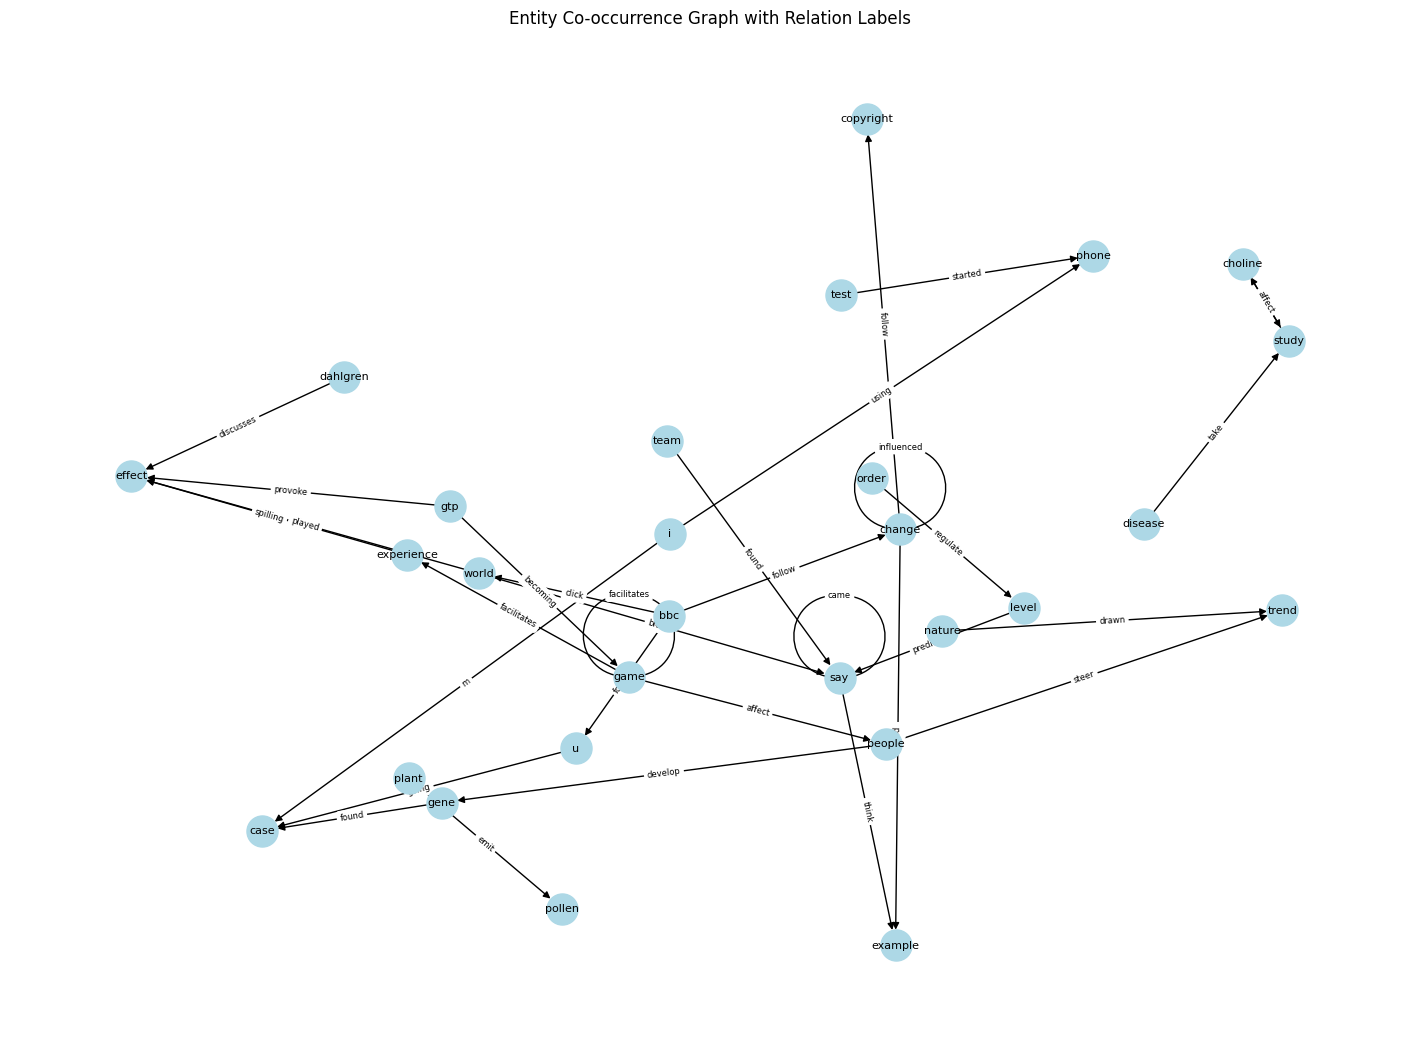

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 100/100 [01:07<00:00,  1.48epoch/s, loss=0.107, prev_loss=0.102] 
Evaluating on cpu:   0%|          | 0.00/569 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 569/569 [00:00<00:00, 1.45ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.41s seconds


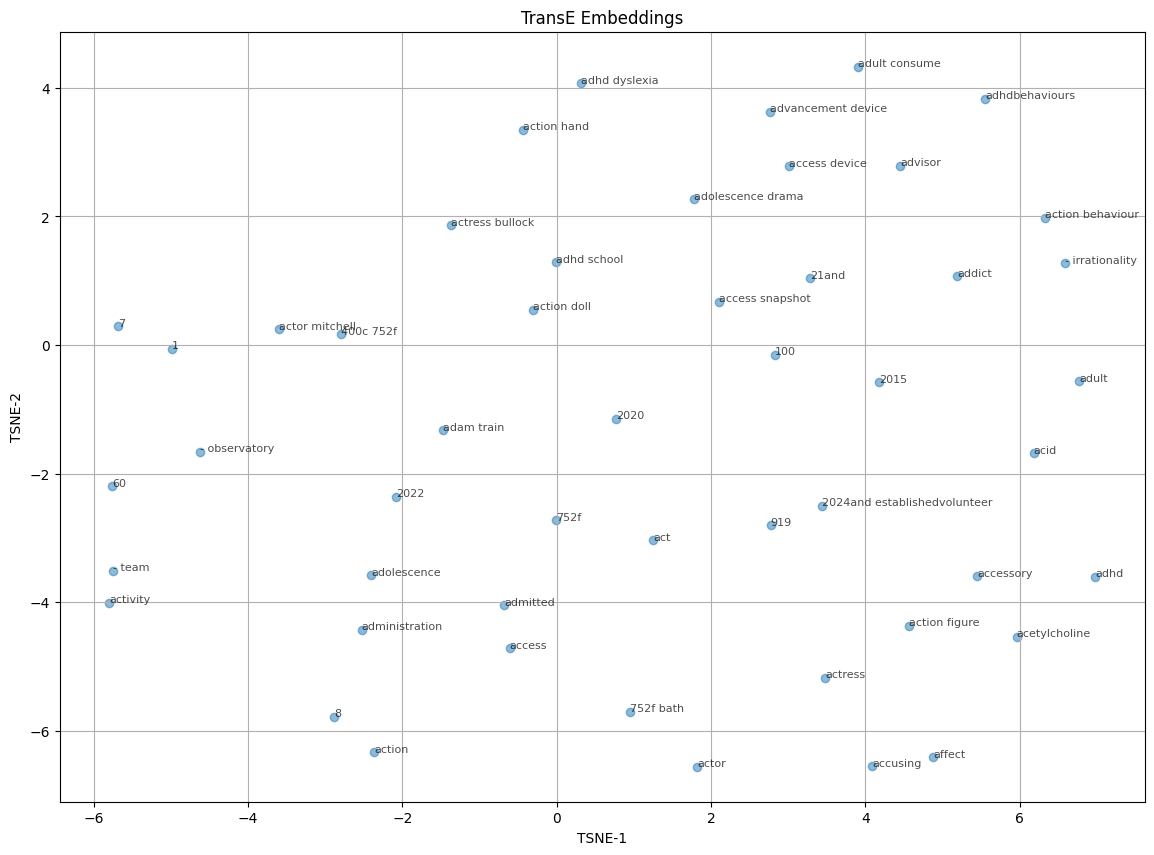

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 100/100 [01:31<00:00,  1.09epoch/s, loss=0.317, prev_loss=0.314]
Evaluating on cpu:   0%|          | 0.00/569 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 569/569 [00:00<00:00, 2.36ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.25s seconds


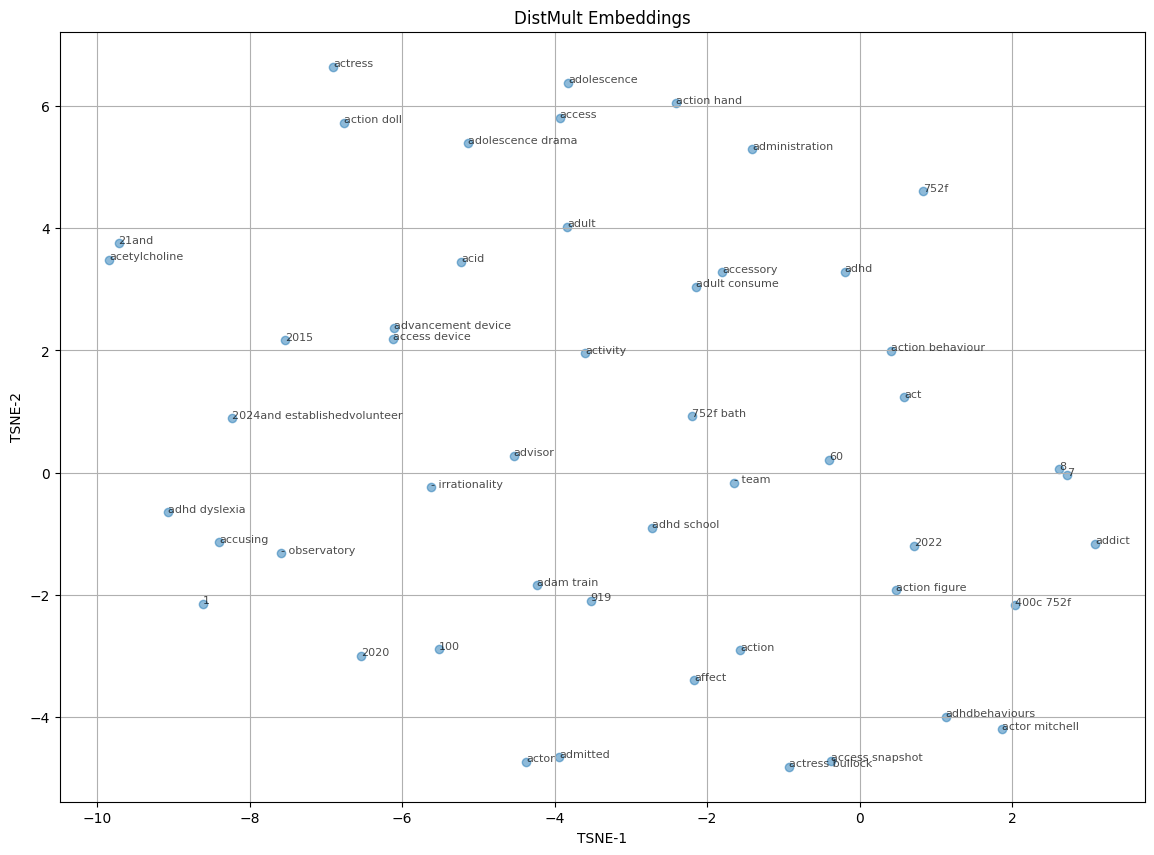

In [114]:
if __name__ == "__main__":
    main()

To compare, when run a comparison with the SPacy model. We define better the extract_relations function with NER;

In [125]:
def get_named_entity(token, entity_dict):
    for i in range(token.i, -1, -1):
        if i in entity_dict:
            return entity_dict[i].text
    return None


In [127]:
def extract_relations(text, nlp):
    doc = nlp(text)
    entities = {ent.start: ent for ent in doc.ents}
    relations = []

    for sent in doc.sents:
        for token in sent:
            if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "VERB":
                subj = get_named_entity(token, entities) or token.text
                pred = token.head.lemma_

                for child in token.head.children:
                    if child.dep_ in ("prep", "agent"):
                        for obj in child.children:
                            if obj.dep_ == "pobj":
                                obj_text = get_named_entity(obj, entities) or obj.text
                                relations.append((subj, pred, obj_text))
                    elif child.dep_ in ("dobj", "attr", "oprd", "acomp"):
                        obj_text = get_named_entity(child, entities) or child.text
                        relations.append((subj, pred, obj_text))
                    elif child.dep_ == "conj":
                        conj_text = get_named_entity(child, entities) or child.text
                        relations.append((subj, pred, conj_text))

            if token.dep_ == "appos" and token.head.dep_ == "nsubj":
                relations.append((token.head.text, "is", token.text))

            if token.dep_ == "compound" and token.head.pos_ in ("NOUN", "PROPN"):
                compound = f"{token.text} {token.head.text}"
                relations.append((compound, "compound_of", token.head.text))

    return list(set(relations))


In [128]:
def main_spacy():
    nlp_ner, nlp = load_models()
    articles = fetch_bbc_articles()
    all_triples = []

    for article in articles:
        raw_text = article['content']
        clean = clean_text(raw_text)
        triples = extract_relations(clean, nlp)
        all_triples.extend(triples)

    if not all_triples:
        print("No triples extracted.")
        return

    print(f"Extracted {len(all_triples)} triples from {len(articles)} articles.")

    plot_entity_graph(all_triples, top_n=40)
    enriched_triples = enrich_graph(all_triples)

    transE_model, transE_factory = train_kg_embedding(enriched_triples, model_name="TransE")
    visualize_embeddings(transE_model, transE_factory, "TransE Embeddings")

    distmult_model, distmult_factory = train_kg_embedding(enriched_triples, model_name="DistMult")
    visualize_embeddings(distmult_model, distmult_factory, "DistMult Embeddings")


Extracted 2823 triples from 10 articles.


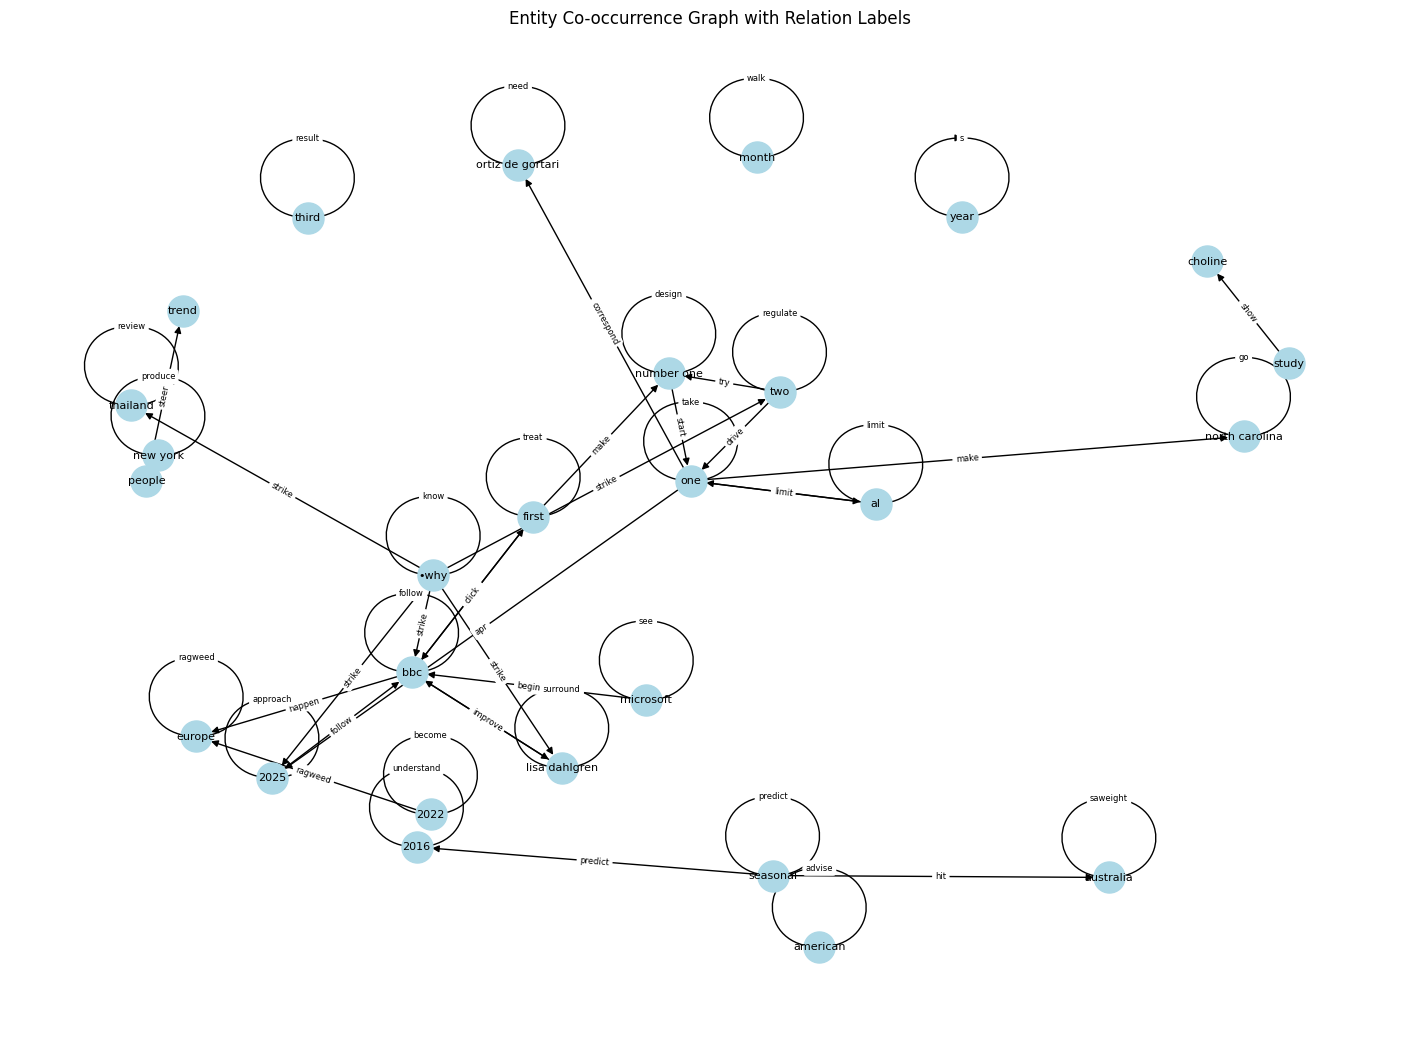

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 100/100 [01:40<00:00,  1.00s/epoch, loss=0.109, prev_loss=0.119] 
Evaluating on cpu:   0%|          | 0.00/545 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 545/545 [00:00<00:00, 1.37ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.42s seconds


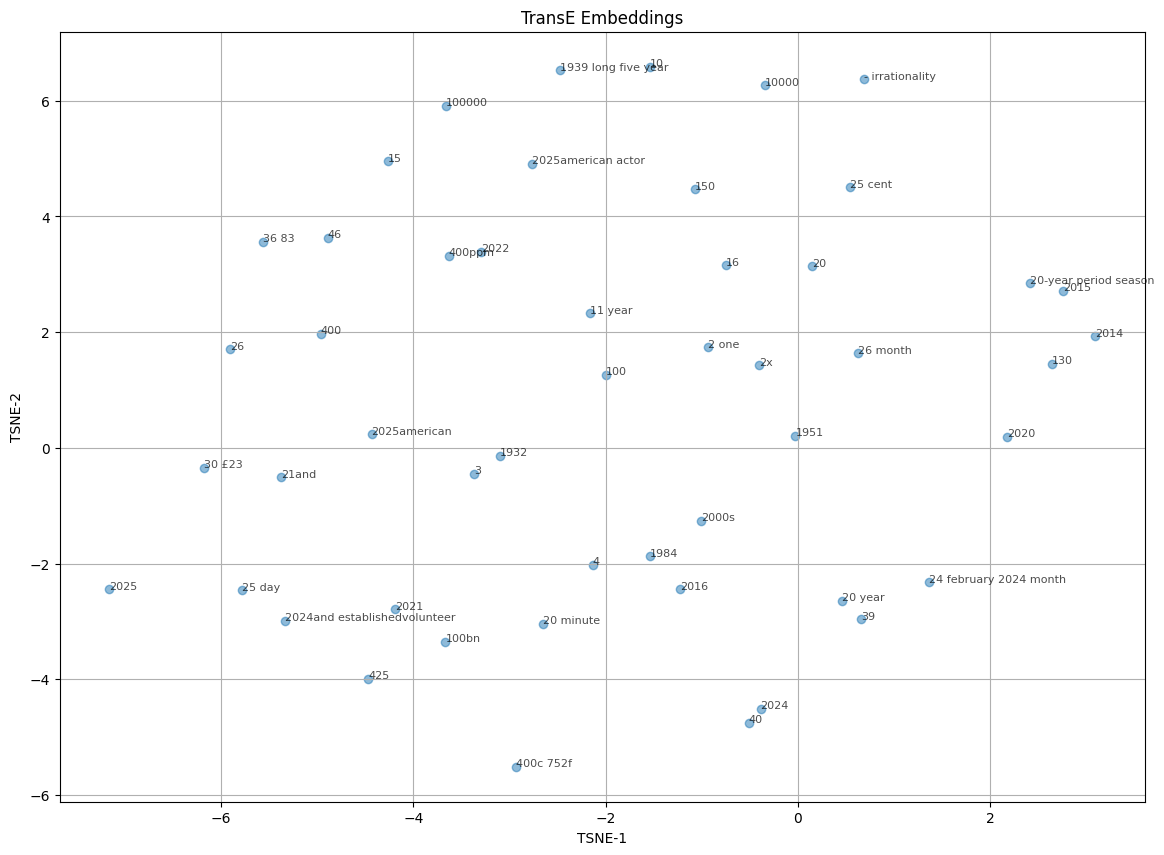

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 100/100 [01:14<00:00,  1.35epoch/s, loss=0.307, prev_loss=0.307]
Evaluating on cpu:   0%|          | 0.00/545 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 545/545 [00:00<00:00, 2.74ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds


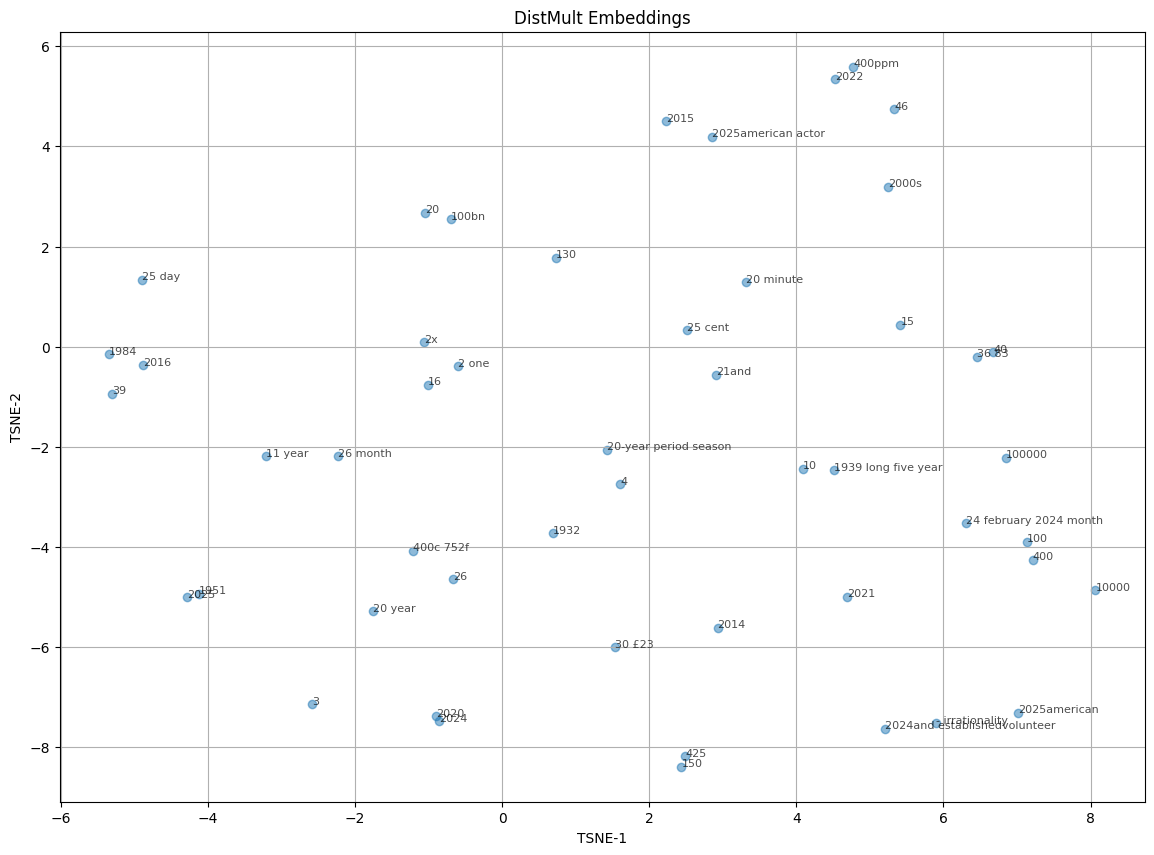

In [129]:
if __name__ == "__main__":
    main_spacy()

By comparing the two models:
Co-occurence graph:
- CRF gave more generic, often grammatically loose triples for example "game -> is -> game", "bbc -> click _> bbc".
- spaCy gives cleaner relations thanks to deeper parsing and better named entity resolution. Named entities are clearly present, the relation labels are more interpretable and there is less noise

Knwledge graph embedding:
- The CRF-based model produced clearer and more meaningful embeddings, with well-formed clusters and specific entities such as “action figure” or “access snapshot.”
- the spaCy pipeline resulted in more generic and noisy terms like “one” or “year,” leading to scattered and less informative embeddings.

- the CRF-based knowledge graph show well-formed clusters of semantically related entities, such as concepts around health, behavior, and technology
- The embeddings from the spaCy-based graph are less informative, heavily populated by generic terms (e.g., numbers, time references), leading to sparse and less interpretable distributions. 

Overall, the CRF model gives more meaningful entity representation.